# Import Libraries

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib

# Read Data

In [2]:
real_data = pd.read_csv('dataset/True.csv')
fake_data = pd.read_csv('dataset/Fake.csv')

In [3]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
real_data.shape

(21417, 4)

In [6]:
fake_data.shape

(23481, 4)

In [7]:
real_data.drop('date', axis=1, inplace=True)
fake_data.drop('date', axis=1, inplace=True)

In [8]:
real_data.head()

,title,text,subject
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews


In [9]:
real_data['label'] = 'real'
fake_data['label'] = 'fake'

In [10]:
fake_data.sample()

,title,text,subject,label
11174,NEW YORK BASED MUSLIM ACTIVIST PRAISES ISIS CH...,The comments on her Facebook page are praising...,politics,fake


In [11]:
real_data.sample()

,title,text,subject,label
3365,Former Corinthian college students await loan ...,WASHINGTON (Reuters) - The U.S. Education Depa...,politicsNews,real


# Combine Real & Fake Data

In [12]:
df = pd.concat([real_data, fake_data], axis=0).reset_index(drop=True)

In [13]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
df.head()

,title,text,subject,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,fake
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,fake
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,fake
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,real
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,fake


In [15]:
df.isnull().sum()

title      0
text       0
subject    0
label      0
dtype: int64

In [16]:
df.describe()

,title,text,subject,label
count,44898,44898,44898,44898
unique,38729,38646,8,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,fake
freq,14,627,11272,23481


# Visualizations

## Class Distribution

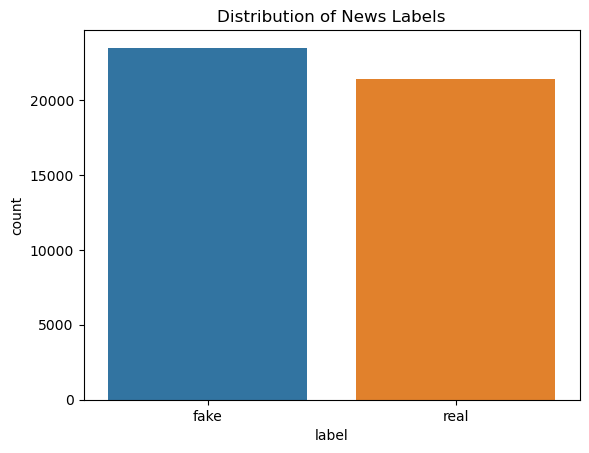

In [17]:
sns.countplot(x='label', data=df, hue='label', palette='tab10')
plt.title("Distribution of News Labels")
plt.show()

## Word Clouds

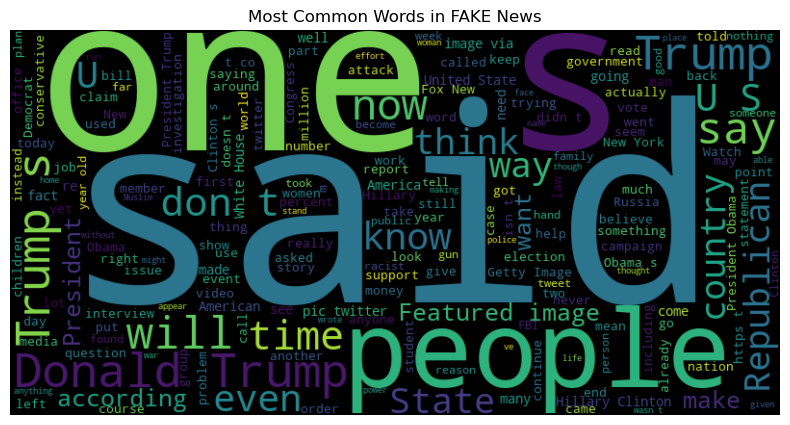

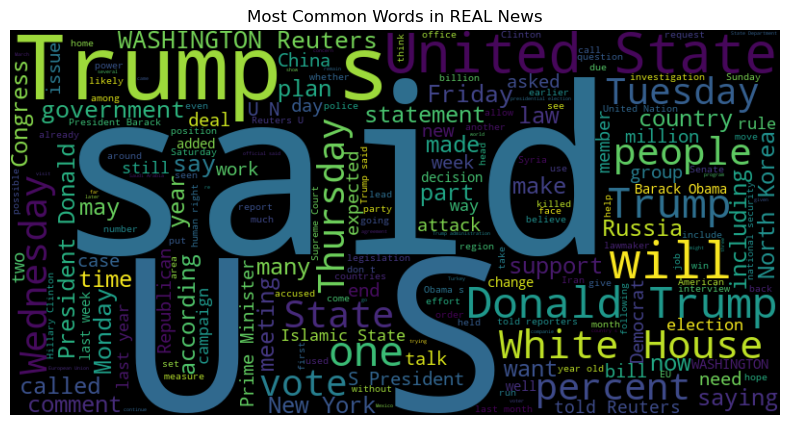

In [18]:
fake_text = ' '.join(df[df['label'] == 'fake']['text'])
real_text = ' '.join(df[df['label'] == 'real']['text'])

wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_text)
wordcloud_real = WordCloud(width=800, height=400, background_color='black').generate(real_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in FAKE News")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in REAL News")
plt.show()

# Data Preprocessing

## Remove Punctuation & Convert Text to Lowercase

In [18]:
def punctuation(column_name):
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x.lower()))
    return df[column_name]

In [19]:
df['title'] = punctuation('title')
df['text'] = punctuation('text')
df['subject'] = punctuation('subject')

In [20]:
df.head()

,title,text,subject,label
0,breaking gop chairman grassley has had enough...,donald trump s white house is in chaos and the...,news,fake
1,failed gop candidates remembered in hilarious...,now that donald trump is the presumptive gop n...,news,fake
2,mike pences new dc neighbors are hilariously ...,mike pence is a huge homophobe he supports exg...,news,fake
3,california ag pledges to defend birth control ...,san francisco reuters california attorney gen...,politicsnews,real
4,az ranchers living on usmexico border destroy ...,twisted reasoning is all that comes from pelos...,politics,fake


## Remove Stopwords

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alaa0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

In [23]:
df['title'] = df['title'].apply(remove_stopwords)

In [24]:
df['text'] = df['text'].apply(remove_stopwords)
df['subject'] = df['subject'].apply(remove_stopwords)

In [25]:
df.head()

,title,text,subject,label
0,breaking gop chairman grassley enough demands ...,donald trump white house chaos trying cover ru...,news,fake
1,failed gop candidates remembered hilarious moc...,donald trump presumptive gop nominee time reme...,news,fake
2,mike pences new dc neighbors hilariously troll...,mike pence huge homophobe supports exgay conve...,news,fake
3,california ag pledges defend birth control ins...,san francisco reuters california attorney gene...,politicsnews,real
4,az ranchers living usmexico border destroy nan...,twisted reasoning comes pelosi days especially...,politics,fake


## Label Encoding

In [26]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [27]:
df['subject'] = le.fit_transform(df['subject'])

In [28]:
df.head()

,title,text,subject,label
0,breaking gop chairman grassley enough demands ...,donald trump white house chaos trying cover ru...,3,0
1,failed gop candidates remembered hilarious moc...,donald trump presumptive gop nominee time reme...,3,0
2,mike pences new dc neighbors hilariously troll...,mike pence huge homophobe supports exgay conve...,3,0
3,california ag pledges defend birth control ins...,san francisco reuters california attorney gene...,5,1
4,az ranchers living usmexico border destroy nan...,twisted reasoning comes pelosi days especially...,4,0


# Feature Engineering (TF-IDF)

In [29]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

## Combine title with text

In [30]:
df['content'] = df['title'] + ' ' + df['text']

In [31]:
X_tfidf = tfidf.fit_transform(df['content'])

In [33]:
y = df['label']

# Train-Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Model Building

In [36]:
logistic_model = LogisticRegression()

In [37]:
logistic_model.fit(X_train, y_train)

LogisticRegression()

# Model Evaluation

In [39]:
y_pred = logistic_model.predict(X_test)

In [40]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.99


In [41]:
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [46]:
f1_score(y_test, y_pred)

0.9909239003956248

# Model Saving using joblib

## Save model

In [44]:
joblib.dump(logistic_model, 'fake_news_model.pkl')

['fake_news_model.pkl']

## Save TF-IDF vectorizer

In [45]:
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']